In [1]:
import gym
import gym_rlio

In [2]:
env = gym.make('rlio-v0')

In [3]:
%%time
env.load_data(
    products_dict={
        4600: [
            555800, 616400, 564900, 582700, 404500, 589400, 582800, 1518900,
            835000, 587400, 617400, 819800, 1843100, 631500, 7562300, 11637400,
            3539700, 3540400, 12906800, 4095600, 886100, 4212800, 706600, 9339400,
            589700, 625700, 560100, 559800, 490400, 1617800, 744200, 720500,
            4285500, 615200, 1453400, 4043300, 571300, 808700, 101300, 6783400
        ]
    }
)


Wall time: 53.8 s


In [4]:
print(env.compute_baseline_realworld())
print('\n---\n')

    store_id  product_id first_appeared last_appeared    sum_reward  \
0       4600      101300     2016-01-01    2019-11-03   -542.659324   
1       4600      404500     2016-01-04    2019-11-29  -8017.240286   
2       4600      490400     2016-01-01    2019-11-03  -2123.140708   
3       4600      555800     2016-01-02    2019-12-30  -4010.000715   
4       4600      559800     2016-01-01    2019-11-03  -6726.942029   
5       4600      560100     2016-01-01    2019-11-03  -4083.492220   
6       4600      564900     2016-01-01    2019-11-29  -1834.571995   
7       4600      571300     2016-01-01    2019-11-03   -274.933561   
8       4600      582700     2016-01-01    2019-11-29 -18774.065919   
9       4600      582800     2016-01-11    2019-11-29   -595.409779   
10      4600      587400     2016-01-01    2019-11-03  -6379.809096   
11      4600      589400     2016-01-10    2019-11-29   -493.893697   
12      4600      589700     2016-01-01    2019-11-03   -631.201787   
13    

<h3>Agent</h3>

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [6]:
tf.__version__

'2.4.1'

In [7]:
tf.random.set_seed(73)
np.random.seed(73)

In [8]:
num_states = 9
num_actions = 2

upper_bound = [1, 20] # ROL - percentage of OUL
lower_bound = [0, 1] # ROL, OUL

# ROL < OUL


print("Size of State Space ->  {}".format(num_states))
print("Size of Action Space ->  {}".format(num_actions))

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  9
Size of Action Space ->  2
Max Value of Action ->  [1, 20]
Min Value of Action ->  [0, 1]


In [9]:
# Buffer stores experiences, when the capacity is exceeded, it starts overriding past data

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

<h4>Actor + Critic</h4>

In [17]:
def get_actor():
    # Initialize weights between -3e-2 and 3-e2
    last_init = tf.random_uniform_initializer(minval=-0.002, maxval=0.002)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(512, activation="relu")(inputs)
    out = layers.Dense(512, activation="relu")(out)
    outputs = layers.Dense(num_actions, activation="sigmoid", kernel_initializer=last_init)(out)

    # Our upper bound
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(512, activation="relu")(concat)
    out = layers.Dense(512, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

<h4>Policy (take action)</h4>

In [18]:
def policy(state, train=True):
    sampled_actions = tf.squeeze(actor_model(state))
    # Adding noise to actions
    if train:
        sampled_actions = sampled_actions.numpy()
        sampled_actions += np.random.normal(loc=0.0, scale=upper_bound, size=sampled_actions.shape) / max(upper_bound)
    else:
        sampled_actions = sampled_actions.numpy()

    # We make sure action is within bounds
    legal_actions = np.clip(sampled_actions, lower_bound, upper_bound)

    if num_actions == 1:
        return [np.squeeze(legal_actions)]
    else:
        return legal_actions

<h4>Environment Helpers</h4>

In [19]:
def env_reward(rewards):
    return list(rewards[4600].values())

In [20]:
def env_state(states):
    states = list(states[4600].values())
    
    vals = []
    for s in states:
        vals.append([
            s['date'].month,
            s['date'].weekday(),
            s['demand'],
            s['flag_promo'],
            s['lead_time'],
            s['mply_qty'],
            s['sales'],
            s['stock'],
            s['service_level']
        ])
    return np.array(vals)

In [21]:
def env_action(actions):
    if actions.ndim == 1:
        actions = np.array([actions])
    return np.stack((np.floor(np.clip(actions[:, 0] - 1e-8, 0, np.inf) * actions[:, 1]), np.ceil(actions[:, 1])), axis=1)

def return_policy(p, keys):
    return {4600: dict(zip(keys, p.tolist()))}

In [22]:
def save_it_reward_history(history, new):
    for k, v in new[4600].items():
        history[k] = history.get(k, []) + [v]
        
    return history

def save_ep_avg_reward_history(history, ep):
    for k, v in ep.items():
        history[k] = history.get(k, []) + [np.mean(v)]
    return history

def save_ep_sum_reward_history(history, ep):
    for k, v in ep.items():
        history[k] = history.get(k, []) + [np.sum(v)]
    return history

<h4>Initialize agent</h4>

In [23]:
# init actor
actor_model = get_actor()
critic_model = get_critic()

# init critic
target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_optimizer = tf.keras.optimizers.Adam(lr=0.0002)
actor_optimizer = tf.keras.optimizers.Adam(lr=0.0001)

total_episodes = 6
# Discount factor for future rewards
gamma = 0.95
# Used to update target networks
tau = 0.04

buffer = Buffer(100000, 256) # capacity, batch_size

<h4>Simulation</h4>

In [24]:
mag_avg_reward_hist = {}
mag_sum_reward_hist = {}

avg_reward_hist = []
sum_reward_hist = []

ep_rewards = []

for ep in range(total_episodes):
    print('Ep', ep+1, 'starts')
    #
    ep_reward = {'avg': [], 'sum': []}
    ep_reward_hist = {}
    # reset environment
    prev_state, reward, done, _ = env.reset()
    
    i = 0
    while True:
        # convert
        prev_state_arr = env_state(prev_state)
        # tensor
        tf_prev_state = tf.convert_to_tensor(prev_state_arr)
        
        # get policy
        actions = policy(tf_prev_state, train=True)
        
        # convert
        env_actions = env_action(actions)

        
        # Recieve state and reward from environment.
        state, reward, done, _ = env.step(return_policy(env_actions, prev_state[4600].keys()))
        # convert
        state_arr = env_state(state)
        # write to buffer
        for p_s, a, r, s in zip(prev_state_arr, actions, env_reward(reward), state_arr):
            buffer.record((p_s, a, r, s))
            
        # save interation reward stats
        ep_reward_hist = save_it_reward_history(ep_reward_hist, reward)
            
        # learn
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        
        # End this episode when `done` is True
        if done or i == 1000:
            break
            
        # move forward in time
        prev_state = state
        #
        i = i+1
        
        # debug
        ep_reward['avg'].append(np.mean(list(reward[4600].values())))
        ep_reward['sum'].append(np.sum(list(reward[4600].values())))
        
        if i % 25 == 0:
            avg_ep_reward = np.mean(list(map(lambda x: np.mean(x), list(ep_reward_hist.values()))))
            sum_ep_reward = np.mean(list(map(lambda x: np.sum(x),  list(ep_reward_hist.values()))))
        
        
            print('Debug {}, Avg mean reward: {}, Avg total reward: {}, Action example: {}'\
                  .format(i, np.round(avg_ep_reward, 3), np.round(sum_ep_reward, 3), env_actions[0]))
           
    # ignoring keys, detailed
    ep_rewards.append(ep_reward)
    
    # save episode reward stats (preserving keys)
    mag_avg_reward_hist = save_ep_avg_reward_history(mag_avg_reward_hist, ep_reward_hist)
    mag_sum_reward_hist = save_ep_sum_reward_history(mag_sum_reward_hist, ep_reward_hist)
    
    #################################################
    ############ print debug information ############
    #################################################
    
    # final average episode reward (ignoring keys)
    avg_ep_reward = np.mean(list(map(lambda x: np.mean(x), list(ep_reward_hist.values()))))
    sum_ep_reward = np.mean(list(map(lambda x: np.sum(x),  list(ep_reward_hist.values()))))
    
    avg_reward_hist.append(avg_ep_reward)
    sum_reward_hist.append(sum_ep_reward)
    
    
    print("---> Episode * {} * Avg Mean Reward is ==> {} * Avg Total Reward is ==> {}"\
         .format(ep+1, np.round(avg_ep_reward, 3), np.round(sum_ep_reward, 3)))

Ep 1 starts
Debug 25, Avg mean reward: -1.428, Avg total reward: -35.514, Action example: [3. 9.]
Debug 50, Avg mean reward: -1.219, Avg total reward: -60.684, Action example: [1. 5.]
Debug 75, Avg mean reward: -1.069, Avg total reward: -79.921, Action example: [0. 1.]
Debug 100, Avg mean reward: -0.912, Avg total reward: -91.039, Action example: [0. 3.]
Debug 125, Avg mean reward: -0.815, Avg total reward: -101.714, Action example: [0. 1.]
Debug 150, Avg mean reward: -0.74, Avg total reward: -110.803, Action example: [0. 1.]
Debug 175, Avg mean reward: -0.696, Avg total reward: -121.746, Action example: [0. 3.]
Debug 200, Avg mean reward: -0.669, Avg total reward: -133.743, Action example: [0. 3.]
Debug 225, Avg mean reward: -0.657, Avg total reward: -147.758, Action example: [0. 2.]
Debug 250, Avg mean reward: -0.637, Avg total reward: -159.078, Action example: [0. 4.]
Debug 275, Avg mean reward: -0.599, Avg total reward: -164.565, Action example: [0. 2.]
Debug 300, Avg mean reward: 

Debug 350, Avg mean reward: -0.001, Avg total reward: -0.371, Action example: [0. 1.]
Debug 375, Avg mean reward: -0.003, Avg total reward: -1.035, Action example: [0. 2.]
Debug 400, Avg mean reward: -0.008, Avg total reward: -3.224, Action example: [0. 1.]
Debug 425, Avg mean reward: -0.01, Avg total reward: -4.406, Action example: [0. 1.]
Debug 450, Avg mean reward: -0.016, Avg total reward: -7.256, Action example: [0. 2.]
Debug 475, Avg mean reward: -0.022, Avg total reward: -10.528, Action example: [0. 1.]
Debug 500, Avg mean reward: -0.03, Avg total reward: -15.156, Action example: [0. 1.]
Debug 525, Avg mean reward: -0.035, Avg total reward: -18.648, Action example: [0. 1.]
Debug 550, Avg mean reward: -0.042, Avg total reward: -23.189, Action example: [0. 1.]
Debug 575, Avg mean reward: -0.048, Avg total reward: -27.526, Action example: [0. 1.]
Debug 600, Avg mean reward: -0.053, Avg total reward: -31.881, Action example: [0. 2.]
Debug 625, Avg mean reward: -0.055, Avg total rewa

Debug 675, Avg mean reward: -0.075, Avg total reward: -50.366, Action example: [0. 1.]
Debug 700, Avg mean reward: -0.074, Avg total reward: -51.945, Action example: [0. 1.]
Debug 725, Avg mean reward: -0.074, Avg total reward: -53.374, Action example: [0. 3.]
Debug 750, Avg mean reward: -0.073, Avg total reward: -54.987, Action example: [0. 1.]
Debug 775, Avg mean reward: -0.072, Avg total reward: -55.576, Action example: [0. 1.]
Debug 800, Avg mean reward: -0.071, Avg total reward: -56.725, Action example: [0. 1.]
Debug 825, Avg mean reward: -0.071, Avg total reward: -58.484, Action example: [0. 1.]
Debug 850, Avg mean reward: -0.07, Avg total reward: -59.802, Action example: [0. 1.]
Debug 875, Avg mean reward: -0.072, Avg total reward: -63.357, Action example: [0. 1.]
Debug 900, Avg mean reward: -0.076, Avg total reward: -67.997, Action example: [0. 1.]
Debug 925, Avg mean reward: -0.079, Avg total reward: -72.752, Action example: [0. 1.]
Debug 950, Avg mean reward: -0.082, Avg tota

In [25]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(ep_rewards[0]['avg'], 20))
plt.plot(moving_average(ep_rewards[1]['avg'], 20))

NameError: name 'plt' is not defined

In [26]:
import json

with open('./hist/DDPG_valid_7.json', mode='w') as f:
    json.dump({
        'avg': mag_avg_reward_hist,
        'sum': mag_sum_reward_hist,
        'ep': ep_rewards
    }, f, indent=2)

In [27]:
actor_model.save('actor_model_v7.h5')

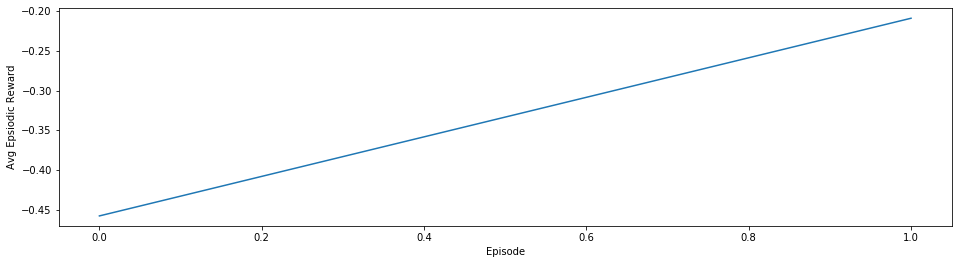

In [34]:
import matplotlib.pyplot as plt
# Plotting graph
# Episodes versus Avg. Rewards
plt.figure(figsize=(16,4));
plt.plot(avg_reward_hist);
plt.xlabel("Episode")
plt.ylabel("Avg Epsiodic Reward")
plt.show()

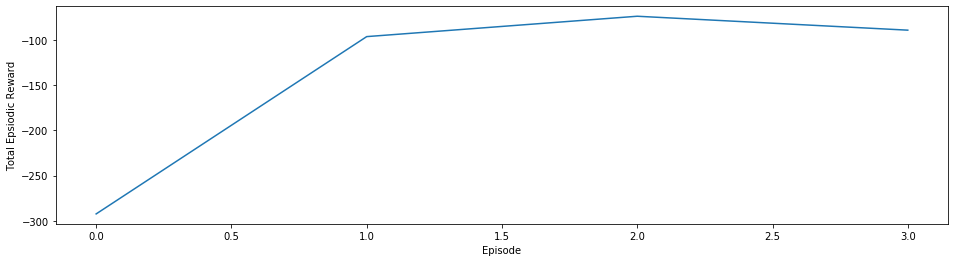

In [32]:
import matplotlib.pyplot as plt
# Plotting graph
# Episodes versus Avg. Rewards
plt.figure(figsize=(16,4));
plt.plot(sum_reward_hist);
plt.xlabel("Episode")
plt.ylabel("Total Epsiodic Reward")
plt.show()

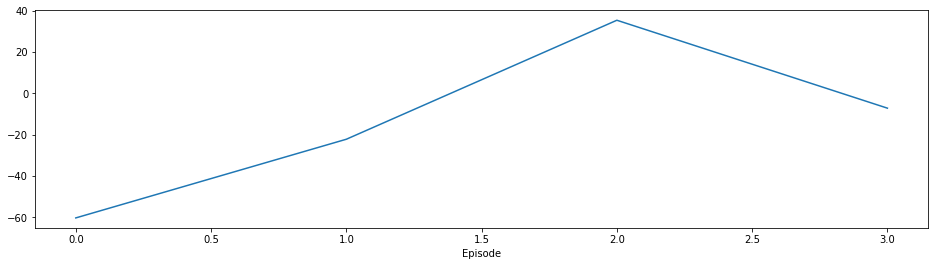

In [33]:
plt.figure(figsize=(16,4));
plt.plot(mag_sum_reward_hist[555800]);
plt.xlabel("Episode")
#plt.ylabel("Total Epsiodic Reward")
plt.show()

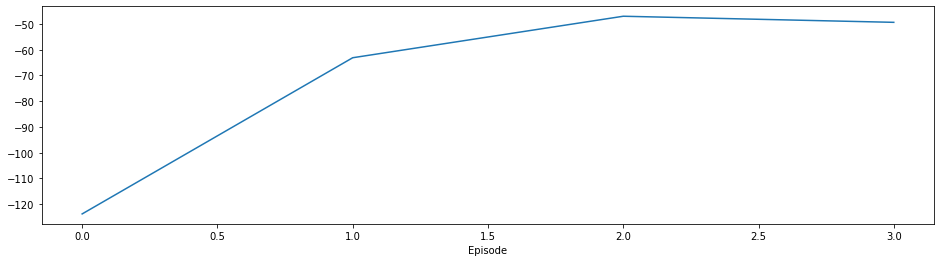

In [34]:
plt.figure(figsize=(16,4));
plt.plot(mag_sum_reward_hist[615200]);
plt.xlabel("Episode")
#plt.ylabel("Total Epsiodic Reward")
plt.show()

In [35]:
x = {}
for k, v in mag_sum_reward_hist.items():
    x[k] = v[-1]

<h3>Validation</h3>

In [28]:
val_mag_avg_reward_hist = {}
val_mag_sum_reward_hist = {}

val_avg_reward_hist = []
val_sum_reward_hist = []

val_ep_rewards = []

for ep in range(1):
    print('Ep', ep+1, 'starts')
    #
    ep_reward = {'avg': [], 'sum': []}
    ep_reward_hist = {}
    # reset environment
    prev_state, reward, done, _ = env.reset()
    
    i = 0
    while True:
        # convert
        prev_state_arr = env_state(prev_state)
        # tensor
        tf_prev_state = tf.convert_to_tensor(prev_state_arr)
        
        # get policy
        actions = policy(tf_prev_state, train=True)
        
        # convert
        env_actions = env_action(actions)
        
        # Recieve state and reward from environment.
        state, reward, done, _ = env.step(return_policy(env_actions, prev_state[4600].keys()))
        # convert
        state_arr = env_state(state)
        
        if i > 1000:
            # save interation reward stats
            ep_reward_hist = save_it_reward_history(ep_reward_hist, reward)
        
        # End this episode when `done` is True
        if done:
            break
            
        # move forward in time
        prev_state = state
        #
        i = i+1
        # debug
        ep_reward['avg'].append(np.mean(list(reward[4600].values())))
        ep_reward['sum'].append(np.sum(list(reward[4600].values())))
        
        if i % 25 == 0:
            avg_ep_reward = np.mean(list(map(lambda x: np.mean(x), list(ep_reward_hist.values()))))
            sum_ep_reward = np.mean(list(map(lambda x: np.sum(x),  list(ep_reward_hist.values()))))
            
            print('Debug {}, Avg mean reward: {}, Avg total reward: {}, Action example: {}'\
                  .format(i, np.round(avg_ep_reward, 3), np.round(sum_ep_reward, 3), env_actions[0]))
            
    # ignoring keys, detailed
    val_ep_rewards.append(ep_reward)
            
    # save episode reward stats (preserving keys)
    val_mag_avg_reward_hist = save_ep_avg_reward_history(val_mag_avg_reward_hist, ep_reward_hist)
    val_mag_sum_reward_hist = save_ep_sum_reward_history(val_mag_sum_reward_hist, ep_reward_hist)
    
    #################################################
    ############ print debug information ############
    #################################################
    
    # final average episode reward (ignoring keys)
    avg_ep_reward = np.mean(list(map(lambda x: np.mean(x), list(ep_reward_hist.values()))))
    sum_ep_reward = np.mean(list(map(lambda x: np.sum(x),  list(ep_reward_hist.values()))))
    
    val_avg_reward_hist.append(avg_ep_reward)
    val_sum_reward_hist.append(sum_ep_reward)
    
    
    print("---> Episode * {} * Avg Mean Reward is ==> {} * Avg Total Reward is ==> {}"\
         .format(ep+1, np.round(avg_ep_reward, 3), np.round(sum_ep_reward, 3)))

Ep 1 starts
Debug 25, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 50, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 75, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 7.]
Debug 100, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 125, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 5.]
Debug 150, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 175, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 200, Avg mean reward: nan, Avg total reward: nan, Action example: [ 0. 12.]
Debug 225, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 9.]
Debug 250, Avg mean reward: nan, Avg total reward: nan, Action example: [ 0. 10.]
Debug 275, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 300, Avg mean reward: nan, Avg total reward: nan, Action example: [0. 1.]
Debug 325, Avg mean reward:

In [29]:
import json

with open('./hist/DDPG_valid_7.json', mode='w') as f:
    json.dump({
        'avg': mag_avg_reward_hist,
        'sum': mag_sum_reward_hist,
        'ep': ep_rewards,
        
        'val_avg': val_mag_avg_reward_hist,
        'val_sum': val_mag_sum_reward_hist,
        'val_ep': val_ep_rewards,
    }, f, indent=2)

In [28]:
import time

In [31]:
prev_state, reward, done, _ = env.reset()
episodic_reward = 0

i = 0
while True:
    prev_state_arr = env_state(prev_state)
    tf_prev_state = tf.convert_to_tensor(prev_state_arr)

    actions = policy(tf_prev_state, False)
    # convert
    env_actions = env_action(actions)

    # Recieve state and reward from environment.
    state, reward, done, _ = env.step(return_policy(env_actions, prev_state[4600].keys()))
    # convert
    state_arr = env_state(state)

    # End this episode when `done` is True
    if done:
        break

    prev_state = state
    i = i+1

    if i % 1 == 0:
        env.render()
        
        time.sleep(1)

02.01.2016 (Day 2 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [1.0, 1.0]  |        0.78 |             -9560.08
      4600 |     404500 | 9             |          0 | [6.0, 7.0]  |       -1.00 |            -19641.90
      4600 |     490400 | 7             |          0 | [1.0, 6.0]  |       -4.33 |            -97626.09
      4600 |     555800 | 10            |          0 | [0.0, 9.0]  |       -1.11 |            -10974.89
      4600 |     559800 | 6             |          7 | [19.0, 20.0] |        5.56 |             17580.46
      4600 |     560100 | 2             |          0 | [1.0, 1.0]  |       -0.62 |            -36705.16
      4600 |     564900 | 6         

04.01.2016 (Day 4 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [1.0, 1.0]  |       -0.11 |             -9560.30
      4600 |     404500 | 9             |          0 | [6.0, 7.0]  |       -1.00 |            -19641.90
      4600 |     490400 | 7             |          0 | [0.0, 8.0]  |       -4.67 |            -97635.43
      4600 |     555800 | 8             |          0 | [2.0, 7.0]  |       -1.84 |            -10978.89
      4600 |     559800 | 6             |          4 | [14.0, 15.0] |        4.56 |             17593.35
      4600 |     560100 | 1             |          0 | [1.0, 1.0]  |       -0.08 |            -36706.31
      4600 |     564900 | 4         

06.01.2016 (Day 6 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [1.0, 1.0]  |       -0.11 |             -9560.53
      4600 |     404500 | 7             |          0 | [0.0, 5.0]  |       -4.67 |            -19650.57
      4600 |     490400 | 6             |          0 | [0.0, 4.0]  |       -4.00 |            -97643.09
      4600 |     555800 | 6             |          0 | [0.0, 4.0]  |       -1.89 |            -10981.31
      4600 |     559800 | 10            |          3 | [16.0, 17.0] |        3.33 |             17600.02
      4600 |     560100 | 1             |          0 | [1.0, 1.0]  |       -0.54 |            -36707.39
      4600 |     564900 | 6         

08.01.2016 (Day 8 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 0             |          1 | [1.0, 1.0]  |        0.00 |             -9559.64
      4600 |     404500 | 4             |          0 | [2.0, 3.0]  |       -2.33 |            -19655.57
      4600 |     490400 | 6             |          0 | [0.0, 6.0]  |       -4.00 |            -97651.09
      4600 |     555800 | 4             |          0 | [2.0, 3.0]  |       -0.58 |            -10982.79
      4600 |     559800 | 7             |          6 | [19.0, 20.0] |        6.22 |             17611.13
      4600 |     560100 | 1             |          0 | [1.0, 1.0]  |       -0.54 |            -36708.47
      4600 |     564900 | 3         

10.01.2016 (Day 10 of 1460)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     101300 | 1             |          0 | [1.0, 1.0]  |       -0.11 |             -9559.75
      4600 |     404500 | 3             |          0 | [1.0, 1.0]  |       -2.00 |            -19659.23
      4600 |     490400 | 5             |          0 | [3.0, 6.0]  |       -3.00 |            -97658.09
      4600 |     555800 | 2             |          0 | [1.0, 1.0]  |       -0.32 |            -10981.36
      4600 |     559800 | 9             |          0 | [12.0, 13.0] |        3.11 |             17618.46
      4600 |     560100 | 1             |          0 | [1.0, 1.0]  |       -0.54 |            -36709.54
      4600 |     564900 | 0        

KeyboardInterrupt: 